# AI Prediction of Michigan Water Use

The primary objective of this project is predicting the future impact on Michigan’s water supply based on archived industry and geographical water consumption levels. More specifically, this project will showcase how water consumption changes over time across industries and counties. Population growth data will also be included as an explanatory variable for the increased demand on the industries. With the annual population data, correlations may be identified across the industries to explain changes in demand. Additionally, highlighting the relationships between industries’ water consumption will provide insight into any underlying effects on water use.
	Although water use data is not available for 2023, the predicted results will be ready to compare with the actual water use results when they become publicly available. Data from the past decade is useful in developing prediction models for 2025 and forecasting future trends. Additionally, aggregate data on the total available water is currently inaccessible. This data would be crucial in identifying the threshold at which the water basin would be critically impacted; so future studies will be required to determine preventative measures. Despite the missing water level data, measuring the current impacts is an important step in predicting high-risk industries


# Libraries

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_palette('PuBuGn')
sns.set_style('dark')
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="seaborn._oldcore")

# Predefined Functions

# Data Upload

The Department of Environment, Great Lakes, and Energy's water usage data for the Great Lakes Basin ranges from 2013 to 2022. The dataset includes a list of the various Michigan counties, industries that reside within those counties, and their annual water consumption. The data does not include population growth data which will be supplemented by the U.S. Census Bureau.

* Unnamed: Index number from merging data
* county: Geographical division of Michigan
* gallons_from_great_lakes: Water use from the Great Lakes
* gallons_from_groundwater: Water use from ground water supplies
* gallons_from_inland_surface: Water use from other resevoirs, lakes, rivers, etc.
* total_gallons_all_sources: Aggregated sum of all gallons
* industry: Distinction of entity type that used each water source
* year: Surveyed year

Martusiuk, O. (n.d.). Michigan water use data (2013 to 2022) [Data set]. Kaggle. https://www.kaggle.com/datasets/oleksiimartusiuk/michigan-water-use-data-2013-to-2022/data

U.S. Census Bureau. (n.d.). State population totals: 2010-2020 [Data set]. U.S. Census Bureau. https://www2.census.gov/programs-surveys/popest/datasets/2010-2020/state/totals/

U.S. Census Bureau. (n.d.). State population totals: 2020-2023 [Data set]. U.S. Census Bureau. https://www2.census.gov/programs-surveys/popest/datasets/2020-2023/state/totals/

In [6]:
pop20 = pd.read_csv('data/nst-est2020-alldata.csv')
pop23 = pd.read_csv('data/NST-EST2023-ALLDATA.csv')
df1 = pd.read_csv('data/water_use_data_2013_to_2022.csv')

# Data Wrangling

## Population Data
The population data for both date ranges provided by the U.S. Census Bureau estimates the number of individuals that reside within the states. For this project, Michigan is the only state that will be retained. All other state information will be dropped. Additionally, the dataset contains over 14 extraneous feature categories that are multiplied by the number of years surveyed within each range. To minimize the dimensionality and prepare them for merging, all features that are not annual total population estimates will be dropped. Future studies may be able to make use of analyses with features like natural deaths, imigration rates, or births; but those types of features fall outside the scope of this project. After all extraneous features and observations have been dropped, a single row will remain with a number of features equal to the date ranges. Those rows will be converted to a single column where each year is a single observation.

### pop20

The years range from 2010 - 2020. There are a total of 166 features that the data set includes, however only 8 features are required from this dataset.

In [10]:
pop20.head()

,SUMLEV,REGION,DIVISION,STATE,NAME,CENSUS2010POP,ESTIMATESBASE2010,POPESTIMATE2010,POPESTIMATE2011,POPESTIMATE2012,...,RNETMIG2011,RNETMIG2012,RNETMIG2013,RNETMIG2014,RNETMIG2015,RNETMIG2016,RNETMIG2017,RNETMIG2018,RNETMIG2019,RNETMIG2020
0,10,0,0,0,United States,308745538,308758105,309327143,311583481,313877662,...,2.561705,2.745929,2.697816,2.980977,3.317393,3.308478,2.926260,2.208328,1.735857,1.450346
1,20,1,0,0,Northeast Region,55317240,55318414,55380764,55608318,55782661,...,0.951355,0.022910,-0.406301,-0.904675,-2.011990,-2.436197,-1.773545,-2.008364,-3.160710,-3.674490
2,20,2,0,0,Midwest Region,66927001,66929737,66975328,67164092,67348275,...,-0.883842,-0.895516,0.062390,-0.697566,-1.320504,-1.176126,-0.487257,-0.800567,-1.205668,-2.011623
3,20,3,0,0,South Region,114555744,114563042,114869421,116019483,117264196,...,5.218129,5.934440,5.373447,6.236211,7.355913,7.220696,6.272594,5.291755,5.479642,5.743507
4,20,4,0,0,West Region,71945553,71946912,72101630,72791588,73482530,...,2.752027,3.083047,3.183793,4.039593,5.004949,5.284859,4.022332,2.968883,1.822074,1.214309


In [11]:
pop20.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57 entries, 0 to 56
Columns: 166 entries, SUMLEV to RNETMIG2020
dtypes: float64(60), int64(103), object(3)
memory usage: 74.1+ KB


In [12]:
pop20_1 = pop20[pop20['NAME'] == 'Michigan']

In [13]:
pop20_2 = pop20_1.loc[:, 'POPESTIMATE2013':'POPESTIMATE2020']

In [14]:
pop20_3 = pop20_2.copy()
pop20_3.columns = pop20_3.columns.str.removeprefix('POPESTIMATE')

In [15]:
pop20_4 = pop20_3.transpose().reset_index()

In [16]:
pop20_5 = pop20_4.rename(columns = {'index': 'year', 27: 'population'})

In [17]:
pop20_6 = pop20_5.copy()
pop20_6['year'] = pop20_6['year'].astype('int')
pop20_6.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   year        8 non-null      int32
 1   population  8 non-null      int64
dtypes: int32(1), int64(1)
memory usage: 228.0 bytes


### pop23

The years range from 2020 - 2023. There are a total of 60 features that the data set includes, however only 8 features are required from this dataset.

In [19]:
pop23.head()

,SUMLEV,REGION,DIVISION,STATE,NAME,ESTIMATESBASE2020,POPESTIMATE2020,POPESTIMATE2021,POPESTIMATE2022,POPESTIMATE2023,...,RNATURALCHG2023,RINTERNATIONALMIG2021,RINTERNATIONALMIG2022,RINTERNATIONALMIG2023,RDOMESTICMIG2021,RDOMESTICMIG2022,RDOMESTICMIG2023,RNETMIG2021,RNETMIG2022,RNETMIG2023
0,10,0,0,0,United States,331464948,331526933,332048977,333271411,334914895,...,1.510043,1.133278,3.003867,3.409196,0.000000,0.000000,0.000000,1.133278,3.003867,3.409196
1,20,1,0,0,Northeast Region,57614141,57430477,57243423,57026847,56983517,...,0.976280,1.403074,3.678035,3.947167,-4.823207,-7.881683,-5.671414,-3.420133,-4.203648,-1.724247
2,30,1,1,0,New England,15119994,15057898,15106108,15120739,15159777,...,-0.019551,1.772643,4.532659,5.024221,1.615767,-3.086263,-2.445863,3.388409,1.446396,2.578358
3,30,1,2,0,Middle Atlantic,42494147,42372579,42137315,41906108,41823740,...,1.336417,1.271165,3.370662,3.557656,-7.121462,-9.606391,-6.837920,-5.850297,-6.235729,-3.280264
4,20,2,0,0,Midwest Region,68987296,68969794,68850246,68783028,68909283,...,0.665803,0.802684,2.098649,2.409866,-2.577042,-2.636615,-1.245226,-1.774357,-0.537966,1.164640


In [20]:
pop23.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66 entries, 0 to 65
Data columns (total 60 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   SUMLEV                 66 non-null     int64  
 1   REGION                 66 non-null     object 
 2   DIVISION               66 non-null     object 
 3   STATE                  66 non-null     int64  
 4   NAME                   66 non-null     object 
 5   ESTIMATESBASE2020      66 non-null     int64  
 6   POPESTIMATE2020        66 non-null     int64  
 7   POPESTIMATE2021        66 non-null     int64  
 8   POPESTIMATE2022        66 non-null     int64  
 9   POPESTIMATE2023        66 non-null     int64  
 10  NPOPCHG_2020           66 non-null     int64  
 11  NPOPCHG_2021           66 non-null     int64  
 12  NPOPCHG_2022           66 non-null     int64  
 13  NPOPCHG_2023           66 non-null     int64  
 14  BIRTHS2020             66 non-null     int64  
 15  BIRTHS20

In [21]:
pop23_1 = pop23[pop23['NAME'] == 'Michigan']

In [22]:
pop23_2 = pop23_1.loc[:, 'POPESTIMATE2020':'POPESTIMATE2022']

In [23]:
pop23_3 = pop23_2.copy()
pop23_3.columns = pop23_3.columns.str.removeprefix('POPESTIMATE')

In [24]:
pop23_4 = pop23_3.transpose().reset_index()

In [25]:
pop23_5 = pop23_4.rename(columns = {'index': 'year', 36: 'population'})

In [26]:
pop23_6 = pop23_5.copy()
pop23_6['year'] = pop23_6['year'].astype('int')
pop23_6.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   year        3 non-null      int32
 1   population  3 non-null      int64
dtypes: int32(1), int64(1)
memory usage: 168.0 bytes


## Concatenating

When concatenating these two tables, the 2023 population date range has a new occurence of the year 2020. This may be due to new methods or information being obtained post-2020 so this occurrence will be treated as the official 2020 population estimate. To join the two tables, pop23 will be concatenated on the end of pop20 as a continuation of the data.

In [28]:
pop20_7 = pop20_6[pop20_5['year'] != '2020']
pop20_7

,year,population
0,2013,9914802
1,2014,9932033
2,2015,9934483
3,2016,9954117
4,2017,9976752
5,2018,9987286
6,2019,9984795


In [29]:
popdf = pd.concat([pop20_7, pop23_6], axis = 0, ignore_index = True)
popdf

,year,population
0,2013,9914802
1,2014,9932033
2,2015,9934483
3,2016,9954117
4,2017,9976752
5,2018,9987286
6,2019,9984795
7,2020,10070627
8,2021,10038117
9,2022,10033281


In [30]:
popdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   year        10 non-null     int32
 1   population  10 non-null     int64
dtypes: int32(1), int64(1)
memory usage: 252.0 bytes


## Water Use Data

The data provided by he Department of Environment, Great Lakes, and Energy comprehensively details the water use for industries, counties, and from various water sources. For this project, policy and controls for high-risk industries is the primary concern; so counties will be removed from the study as residential uses fall outside the scope of this project. Additionally, the original index from when Martusiuk merged the datasets has no bearing as a feature; so it will be removed.

In [32]:
df1.head()

,Unnamed: 0,county,gallons_from_great_lakes,gallons_from_groundwater,gallons_from_inland_surface,total_gallons_all_sources,industry,year
0,0,Alcona,0,2666085962,4695086047,7361172009,Total All Sectors,2014
1,1,Alger,1512160000,1608226431,799089999,3919476431,Total All Sectors,2014
2,2,Allegan,0,5552539983,3784550040,9337090023,Total All Sectors,2014
3,3,Alpena,40839120000,10948600250,2532270000,54319990250,Total All Sectors,2014
4,4,Antrim,0,12214548686,54526097,12269074783,Total All Sectors,2014


In [33]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6630 entries, 0 to 6629
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   Unnamed: 0                   6630 non-null   int64 
 1   county                       6630 non-null   object
 2   gallons_from_great_lakes     6630 non-null   int64 
 3   gallons_from_groundwater     6630 non-null   int64 
 4   gallons_from_inland_surface  6630 non-null   int64 
 5   total_gallons_all_sources    6630 non-null   int64 
 6   industry                     6630 non-null   object
 7   year                         6630 non-null   int64 
dtypes: int64(6), object(2)
memory usage: 414.5+ KB


### Dropping Features

In addition to dropping the unnecessary columns, water source columns will be abbreviated to remove gallon indicators since all of these units are synonymous. Renaming the features will enable cleaner referencing for future manipulation.

In [35]:
df2 = df1.drop(columns = ['Unnamed: 0', 'county']).rename(columns = {
    'gallons_from_great_lakes': 'great_lakes',
    'gallons_from_groundwater': 'groundwater',
    'gallons_from_inland_surface': 'inland',
    'total_gallons_all_sources': 'total'
})

### Rearranging

Year is the main explanatory variable to understand how water use per industry changes over time. Additionally, all other features are divided by industry. After aggregation, population data will be arranged between year and industry features because population is a response variable to the year but not to the industry. Industry being the driving explanatory variable for the water sources will be grouped to the left of the water source features. This rearrangement of features would then put total at the end of the DataFrame because it is the response variable to the different sources.

In [37]:
df2_cols = ['year', 'industry', 'inland', 'great_lakes', 'groundwater', 'total']
df3 = df2[df2_cols]

In [38]:
df3.shape

(6630, 6)

In [39]:
df3['year'].value_counts()

year
2014    664
2018    664
2021    664
2022    664
2016    664
2013    664
2019    664
2017    664
2020    664
2015    654
Name: count, dtype: int64

The industry feature has 8 values in total describing the various industry sectors that Michigan has divided its water use by. The value 'Total All Sectors', is a summation of all other industry values. During EDA and modeling, this value will be analyzed separately to prevent artificially weighing those features.

In [41]:
df3['industry'].value_counts()

industry
Total All Sectors            830
Commercial-Institutional     830
Electric Power Generation    830
Irrigation                   830
Livestock                    830
Other                        830
Public Water Supply          830
Industrial-Manufacturing     820
Name: count, dtype: int64

### Aggregation

Because counties have been removed from analysis, the DataFrame will now need to be aggregated to remove multiple counts of the explanatory features: year and industry. All aggregated features will be sum totalled. Even though this is a reduction in the number of observations, the weights of the individual observations will now be true to the year's estimations.

In [43]:
df4 = df3.groupby(by = ['year', 'industry']).agg('sum').reset_index()
df4.head()

,year,industry,inland,great_lakes,groundwater,total
0,2013,Commercial-Institutional,126374387,1266400,2794492157,2922132944
1,2013,Electric Power Generation,391466708822,2531554552320,1085990916,2924107252058
2,2013,Industrial-Manufacturing,118823433041,111853330944,39327552184,270004316169
3,2013,Irrigation,42803613219,207733128,121431654825,164443001172
4,2013,Livestock,8345185168,0,9882541420,18227726588


In [44]:
df4.shape

(80, 6)

## Joining Population to Water Use

Now that the data has been aggregated and cleaned, the two DataFrames are now ready to be merged. Population will be merged to the water use data as a one-to-many relationship. Population data, like 'year', will be replicated throughout the DataFrame. The repetition of this data will not impact modeling since EDA will account for the relationships between the features.

In [46]:
df5 = df4.merge(popdf, how = 'left', on = 'year')
df5.head()

,year,industry,inland,great_lakes,groundwater,total,population
0,2013,Commercial-Institutional,126374387,1266400,2794492157,2922132944,9914802
1,2013,Electric Power Generation,391466708822,2531554552320,1085990916,2924107252058,9914802
2,2013,Industrial-Manufacturing,118823433041,111853330944,39327552184,270004316169,9914802
3,2013,Irrigation,42803613219,207733128,121431654825,164443001172,9914802
4,2013,Livestock,8345185168,0,9882541420,18227726588,9914802


### Rearrangement

As mentioned previously, population will be moved between 'year' and 'industry' because it is assumed to only be a function of time; not industry. Additionally, for organizational purposes, the data will be sorted by year, then by industry.

In [48]:
df6_col = ['year', 'population', 'industry', 'great_lakes', 'groundwater', 'inland', 'total']

In [49]:
df6 = df5[df6_col].sort_values(['year', 'industry'])

In [50]:
df6.head(10)

,year,population,industry,great_lakes,groundwater,inland,total
0,2013,9914802,Commercial-Institutional,1266400,2794492157,126374387,2922132944
1,2013,9914802,Electric Power Generation,2531554552320,1085990916,391466708822,2924107252058
2,2013,9914802,Industrial-Manufacturing,111853330944,39327552184,118823433041,270004316169
3,2013,9914802,Irrigation,207733128,121431654825,42803613219,164443001172
4,2013,9914802,Livestock,0,9882541420,8345185168,18227726588
5,2013,9914802,Other,164337600,2048536695,775839170,2988713465
6,2013,9914802,Public Water Supply,274498809256,81445974953,5649455350,361594239565
7,2013,9914802,Total All Sectors,2918280029648,258016743163,567990609157,3744287381973
8,2014,9932033,Commercial-Institutional,1328700,2646046489,975901711,3623276900
9,2014,9932033,Electric Power Generation,2506268739829,1586444335,379306798040,2887161982204


In [51]:
df6.shape

(80, 7)

### Null Values

These data sets did not come with any null values initially; however, null values will be checked in the event of a corrrupted file.

In [53]:
df6.isna().sum()

year           0
population     0
industry       0
great_lakes    0
groundwater    0
inland         0
total          0
dtype: int64

### Year Data Type

For EDA time series analysis, the years will be adjusted from integer to a datetime object and set as the index. Since there are seven rows eight rows for each year, time indexing for ARIMA time series analysis will be done later. All datetime objects and year indexing will be reverted back to integers as part of the preprocessing.

In [55]:
df6.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80 entries, 0 to 79
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   year         80 non-null     int64 
 1   population   80 non-null     int64 
 2   industry     80 non-null     object
 3   great_lakes  80 non-null     int64 
 4   groundwater  80 non-null     int64 
 5   inland       80 non-null     int64 
 6   total        80 non-null     int64 
dtypes: int64(6), object(1)
memory usage: 4.5+ KB


In [56]:
df = df6.copy()
df['year'] = pd.to_datetime(df['year'], format = '%Y')

In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80 entries, 0 to 79
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   year         80 non-null     datetime64[ns]
 1   population   80 non-null     int64         
 2   industry     80 non-null     object        
 3   great_lakes  80 non-null     int64         
 4   groundwater  80 non-null     int64         
 5   inland       80 non-null     int64         
 6   total        80 non-null     int64         
dtypes: datetime64[ns](1), int64(5), object(1)
memory usage: 4.5+ KB


# Exploratory Data Analysis

The goal of this project is to forecast Michigan's water use; using industries as a potential explanatory feature. To better understand this, water use data for each industry will be plotted over the years to understand how it changes over time. Additionally, correlations between industries must be drawn to see if there are any underlying relationships between changes over time. Lastly, each industry will be analyzed using the autocorrelation function to show any relationships from the data within itself over time.

* How does water use change over time?
* How do the different industries relate to one another?
* Do the industries have annual change patterns?

For simplicity in syntax, sets will be extracted from the data for easy referencing in the plots.

In [60]:
year = df['year'].values
pop = popdf['population'].values

# Commercial-Institutional
ci_great = df[df['industry'] == 'Commercial-Institutional']['great_lakes'].values
ci_ground = df[df['industry'] == 'Commercial-Institutional']['groundwater'].values
ci_inland = df[df['industry'] == 'Commercial-Institutional']['inland'].values
ci_total = df[df['industry'] == 'Commercial-Institutional']['total'].values

# Electric Power Generation
epg_great = df[df['industry'] == 'Electric Power Generation']['great_lakes'].values
epg_ground = df[df['industry'] == 'Electric Power Generation']['groundwater'].values
epg_inland = df[df['industry'] == 'Electric Power Generation']['inland'].values
epg_total = df[df['industry'] == 'Electric Power Generation']['total'].values

# Industrial-Manufacturing
im_great = df[df['industry'] == 'Industrial-Manufacturing']['great_lakes'].values
im_ground = df[df['industry'] == 'Industrial-Manufacturing']['groundwater'].values
im_inland = df[df['industry'] == 'Industrial-Manufacturing']['inland'].values
im_total = df[df['industry'] == 'Industrial-Manufacturing']['total'].values

# Irrigation
i_great = df[df['industry'] == 'Irrigation']['great_lakes'].values
i_ground = df[df['industry'] == 'Irrigation']['groundwater'].values
i_inland = df[df['industry'] == 'Irrigation']['inland'].values
i_total = df[df['industry'] == 'Irrigation']['total'].values

# Livestock
l_great = df[df['industry'] == 'Livestock']['great_lakes'].values
l_ground = df[df['industry'] == 'Livestock']['groundwater'].values
l_inland = df[df['industry'] == 'Livestock']['inland'].values
l_total = df[df['industry'] == 'Livestock']['total'].values

# Other
o_great = df[df['industry'] == 'Other']['great_lakes'].values
o_ground = df[df['industry'] == 'Other']['groundwater'].values
o_inland = df[df['industry'] == 'Other']['inland'].values
o_total = df[df['industry'] == 'Other']['total'].values

# Public Water Supply
pws_great = df[df['industry'] == 'Public Water Supply']['great_lakes'].values
pws_ground = df[df['industry'] == 'Public Water Supply']['groundwater'].values
pws_inland = df[df['industry'] == 'Public Water Supply']['inland'].values
pws_total = df[df['industry'] == 'Public Water Supply']['total'].values

# Total All Sectors
t_great = df[df['industry'] == 'Total All Sectors']['great_lakes'].values
t_ground = df[df['industry'] == 'Total All Sectors']['groundwater'].values
t_inland = df[df['industry'] == 'Total All Sectors']['inland'].values
t_total = df[df['industry'] == 'Total All Sectors']['total'].values

## How does water use change over time?

To answer this question, industry water use data for each of the water sources (Great Lakes, Groundwater, Inland, and Total) will be plotted over years to show the industry trends. Initial regression will be analyzed to see whether or not linear relationships exist by industry. 

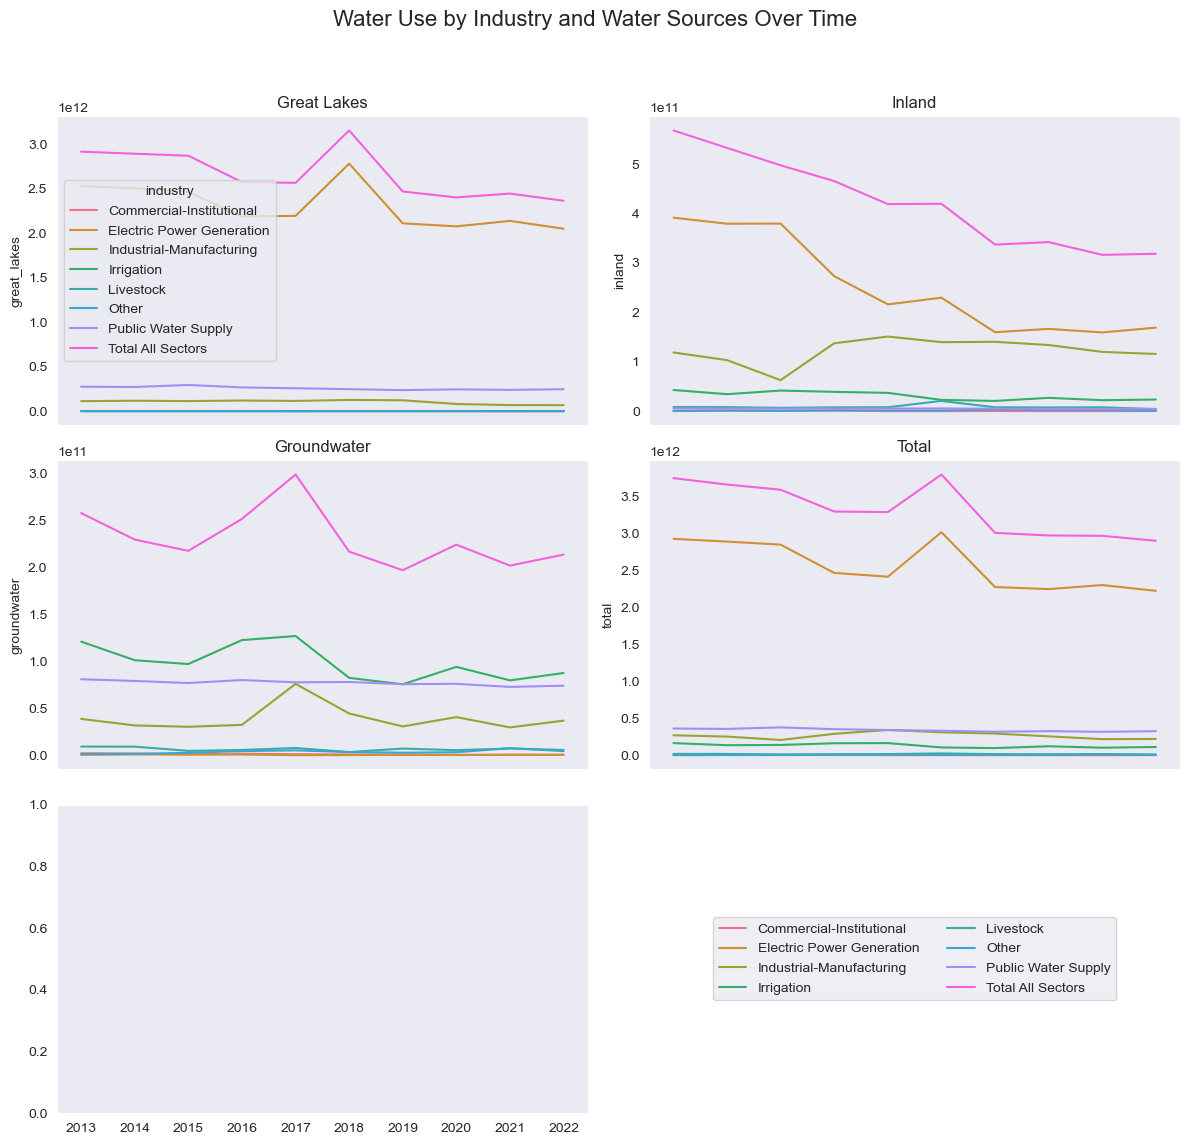

In [118]:
fig, ax = plt.subplots(3, 2, sharex=True, figsize=(12, 12))
sns.lineplot(data = df, x = 'year', y = 'great_lakes', hue = 'industry', ax = ax[0, 0], legend = True).set_title('Great Lakes')
sns.lineplot(data = df, x = 'year', y = 'groundwater', hue = 'industry', ax = ax[1, 0], legend = False).set_title('Groundwater')
sns.lineplot(data = df, x = 'year', y = 'inland', hue = 'industry', ax = ax[0, 1], legend = False).set_title('Inland')
sns.lineplot(data = df, x = 'year', y = 'total', hue = 'industry', ax = ax[1, 1], legend = False).set_title('Total')
ax[-1, -1].axis('off')
handles, labels = ax[0, 0].get_legend_handles_labels()
ax[-1, -1].legend(handles, labels, loc = 'center', ncol = 2)
fig.suptitle('Water Use by Industry and Water Sources Over Time', fontsize = 16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
# plt.savefig('figures/troubleshooting.png')
plt.show()

fig, ax = plt.subplots(2, 2, sharex = True, figsize = (12, 8))
ax[0, 0] = sns.lineplot(data = df, x = 'year', y = 'great_lakes', hue = 'industry', ax = ax[0, 0])
ax[0, 0].set_title('Great Lakes')
ax[0, 0].set_axis_labels('Water Use (gallons)')
sns.lineplot(data = df, x = 'year', y = 'groundwater', hue = 'industry', ax = ax[1, 0]).set_title('Groundwater')
sns.lineplot(data = df, x = 'year', y = 'inland', hue = 'industry', ax = ax[0, 1]).set_title('Inland')
sns.lineplot(data = df, x = 'year', y = 'total', hue = 'industry', ax = ax[1, 1]).set_title('Total')
fig.suptitle('Water Use by Industry and Water Sources Over Time', fontsize = 16)
plt.show()

For most sources, electric power generation seems to be the most impactful industry on water use. The distribution of water use for all sectors most closely follows the pattern of electric power generation. This changes specifically with groundwater sources where almost no water is used in electric power generation. All other industries use less than half a billion gallons 

In [114]:
5*(10**12)

5000000000000